# Phase 1: Data Pipeline Validation

This notebook validates the Phase 1 data infrastructure:
1. Exchange data ingestion (Coinbase)
2. TimescaleDB storage and retrieval
3. Data quality checks

**Pass Criteria:**
- Can fetch live data from Coinbase
- Database contains 90 days of hourly OHLCV data
- No missing timestamps in time series
- Data values are within reasonable ranges

In [1]:
# Setup
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

print(f"Project root: {project_root}")

Project root: /home/sethz/projects/crypto-trading-research


## 1. Test Exchange Connection

In [2]:
from data.ingestion.exchanges import ExchangeDataIngester

# Initialize connection to Coinbase
ingester = ExchangeDataIngester(exchange_name='coinbase')

# Test connection
connection_ok = ingester.test_connection()
print(f"\n✓ Exchange connection: {'PASSED' if connection_ok else 'FAILED'}")

assert connection_ok, "Exchange connection failed!"


✓ Exchange connection: PASSED


In [3]:
# Fetch a small sample of live data
sample_df = ingester.fetch_ohlcv('BTC/USD', timeframe='1h', limit=10)

print(f"Fetched {len(sample_df)} live candles:")
print(sample_df[['time', 'open', 'high', 'low', 'close', 'volume']].tail())

assert len(sample_df) > 0, "Failed to fetch live data"
print("\n✓ Live data fetch: PASSED")

Fetched 10 live candles:
                       time      open      high       low     close  \
5 2025-12-03 22:00:00+00:00  93717.38  94181.41  93318.93  93798.43   
6 2025-12-03 23:00:00+00:00  93802.00  94116.00  93400.99  93453.84   
7 2025-12-04 00:00:00+00:00  93452.02  93505.38  92686.58  93075.91   
8 2025-12-04 01:00:00+00:00  93075.46  93772.68  92994.05  93210.00   
9 2025-12-04 02:00:00+00:00  93210.00  93463.23  93141.01  93462.37   

       volume  
5  381.024376  
6  451.103973  
7  485.203286  
8  272.679271  
9   36.516533  

✓ Live data fetch: PASSED


## 2. Test Database Connection

In [4]:
from data.storage.timeseries_db import TimeSeriesDB

# Initialize database connection
db = TimeSeriesDB()

# Health check
health = db.health_check()
print(f"Database health: {health}")

assert health['status'] == 'healthy', "Database connection unhealthy!"
print("\n✓ Database connection: PASSED")

Database health: {'status': 'healthy', 'connected': True, 'ohlcv_rows': 4310, 'features_rows': 0, 'host': 'localhost', 'database': 'crypto_trading'}

✓ Database connection: PASSED


In [5]:
# Check data stats
stats = db.get_symbol_stats()
print("Symbol statistics:")
print(stats)

assert len(stats) >= 2, "Expected at least 2 symbols (BTC/USD, ETH/USD)"
print("\n✓ Data available for multiple symbols: PASSED")

Symbol statistics:
    symbol  row_count                first_time                 last_time
0  BTC/USD       2155 2025-09-05 03:00:00+00:00 2025-12-04 02:00:00+00:00
1  ETH/USD       2155 2025-09-05 03:00:00+00:00 2025-12-04 02:00:00+00:00

✓ Data available for multiple symbols: PASSED


/home/sethz/projects/crypto-trading-research/data/storage/timeseries_db.py:310: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(exchange,))


## 3. Validate Historical Data

In [6]:
# Fetch BTC/USD data
btc_df = db.fetch_ohlcv('BTC/USD', days=90)

print(f"BTC/USD data:")
print(f"  Rows: {len(btc_df):,}")
print(f"  Date range: {btc_df['time'].min()} to {btc_df['time'].max()}")
print(f"  Price range: ${btc_df['close'].min():,.2f} - ${btc_df['close'].max():,.2f}")

# Check we have at least 80 days of hourly data (some tolerance)
expected_min_rows = 80 * 24  # 80 days * 24 hours
assert len(btc_df) >= expected_min_rows, f"Expected at least {expected_min_rows} rows, got {len(btc_df)}"

print(f"\n✓ BTC/USD data volume: PASSED ({len(btc_df):,} rows)")

BTC/USD data:
  Rows: 2,155
  Date range: 2025-09-05 03:00:00+00:00 to 2025-12-04 02:00:00+00:00
  Price range: $82,104.02 - $126,099.22

✓ BTC/USD data volume: PASSED (2,155 rows)


/home/sethz/projects/crypto-trading-research/data/storage/timeseries_db.py:246: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [7]:
# Fetch ETH/USD data
eth_df = db.fetch_ohlcv('ETH/USD', days=90)

print(f"ETH/USD data:")
print(f"  Rows: {len(eth_df):,}")
print(f"  Date range: {eth_df['time'].min()} to {eth_df['time'].max()}")
print(f"  Price range: ${eth_df['close'].min():,.2f} - ${eth_df['close'].max():,.2f}")

assert len(eth_df) >= expected_min_rows, f"Expected at least {expected_min_rows} rows, got {len(eth_df)}"

print(f"\n✓ ETH/USD data volume: PASSED ({len(eth_df):,} rows)")

ETH/USD data:
  Rows: 2,155
  Date range: 2025-09-05 03:00:00+00:00 to 2025-12-04 02:00:00+00:00
  Price range: $2,677.58 - $4,758.44

✓ ETH/USD data volume: PASSED (2,155 rows)


/home/sethz/projects/crypto-trading-research/data/storage/timeseries_db.py:246: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


## 4. Data Quality Checks

In [8]:
def check_data_quality(df, symbol):
    """Perform quality checks on OHLCV data."""
    issues = []
    
    # Check for NaN values
    nan_counts = df[['open', 'high', 'low', 'close', 'volume']].isna().sum()
    if nan_counts.sum() > 0:
        issues.append(f"NaN values found: {nan_counts.to_dict()}")
    
    # Check OHLC relationships (high >= low, high >= open/close, low <= open/close)
    bad_hl = (df['high'] < df['low']).sum()
    if bad_hl > 0:
        issues.append(f"{bad_hl} rows where high < low")
    
    bad_high = ((df['high'] < df['open']) | (df['high'] < df['close'])).sum()
    if bad_high > 0:
        issues.append(f"{bad_high} rows where high is not the highest")
    
    bad_low = ((df['low'] > df['open']) | (df['low'] > df['close'])).sum()
    if bad_low > 0:
        issues.append(f"{bad_low} rows where low is not the lowest")
    
    # Check for negative values
    neg_values = (df[['open', 'high', 'low', 'close', 'volume']] < 0).sum().sum()
    if neg_values > 0:
        issues.append(f"{neg_values} negative values found")
    
    # Check for zero volume
    zero_vol = (df['volume'] == 0).sum()
    if zero_vol > len(df) * 0.05:  # More than 5% zero volume is suspicious
        issues.append(f"{zero_vol} rows with zero volume ({zero_vol/len(df)*100:.1f}%)")
    
    # Report
    print(f"\nData quality for {symbol}:")
    if issues:
        for issue in issues:
            print(f"  ⚠ {issue}")
    else:
        print("  ✓ All checks passed")
    
    return len(issues) == 0

btc_quality = check_data_quality(btc_df, 'BTC/USD')
eth_quality = check_data_quality(eth_df, 'ETH/USD')

assert btc_quality, "BTC/USD data quality check failed"
assert eth_quality, "ETH/USD data quality check failed"

print("\n✓ Data quality checks: PASSED")


Data quality for BTC/USD:
  ✓ All checks passed

Data quality for ETH/USD:
  ✓ All checks passed

✓ Data quality checks: PASSED


In [9]:
# Check for time gaps (missing candles)
def check_time_continuity(df, symbol, expected_freq='1h'):
    """Check for gaps in time series."""
    df = df.sort_values('time')
    time_diffs = df['time'].diff().dropna()
    
    expected_diff = pd.Timedelta(expected_freq)
    gaps = time_diffs[time_diffs > expected_diff * 1.5]  # Allow some tolerance
    
    print(f"\nTime continuity for {symbol}:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Expected interval: {expected_freq}")
    print(f"  Gaps found: {len(gaps)}")
    
    if len(gaps) > 0:
        print(f"  ⚠ Gap details:")
        for idx in gaps.index[:5]:  # Show first 5 gaps
            gap_size = gaps.loc[idx]
            print(f"    {df.loc[idx-1, 'time']} -> {df.loc[idx, 'time']} ({gap_size})")
    
    # Allow up to 1% gaps (exchanges sometimes have outages)
    gap_ratio = len(gaps) / len(df)
    return gap_ratio < 0.01

btc_continuous = check_time_continuity(btc_df, 'BTC/USD')
eth_continuous = check_time_continuity(eth_df, 'ETH/USD')

assert btc_continuous, "Too many gaps in BTC/USD time series"
assert eth_continuous, "Too many gaps in ETH/USD time series"

print("\n✓ Time continuity checks: PASSED")


Time continuity for BTC/USD:
  Total rows: 2,155
  Expected interval: 1h
  Gaps found: 1
  ⚠ Gap details:
    2025-10-25 15:00:00+00:00 -> 2025-10-25 21:00:00+00:00 (0 days 06:00:00)

Time continuity for ETH/USD:
  Total rows: 2,155
  Expected interval: 1h
  Gaps found: 1
  ⚠ Gap details:
    2025-10-25 15:00:00+00:00 -> 2025-10-25 21:00:00+00:00 (0 days 06:00:00)

✓ Time continuity checks: PASSED


## 5. Visual Inspection

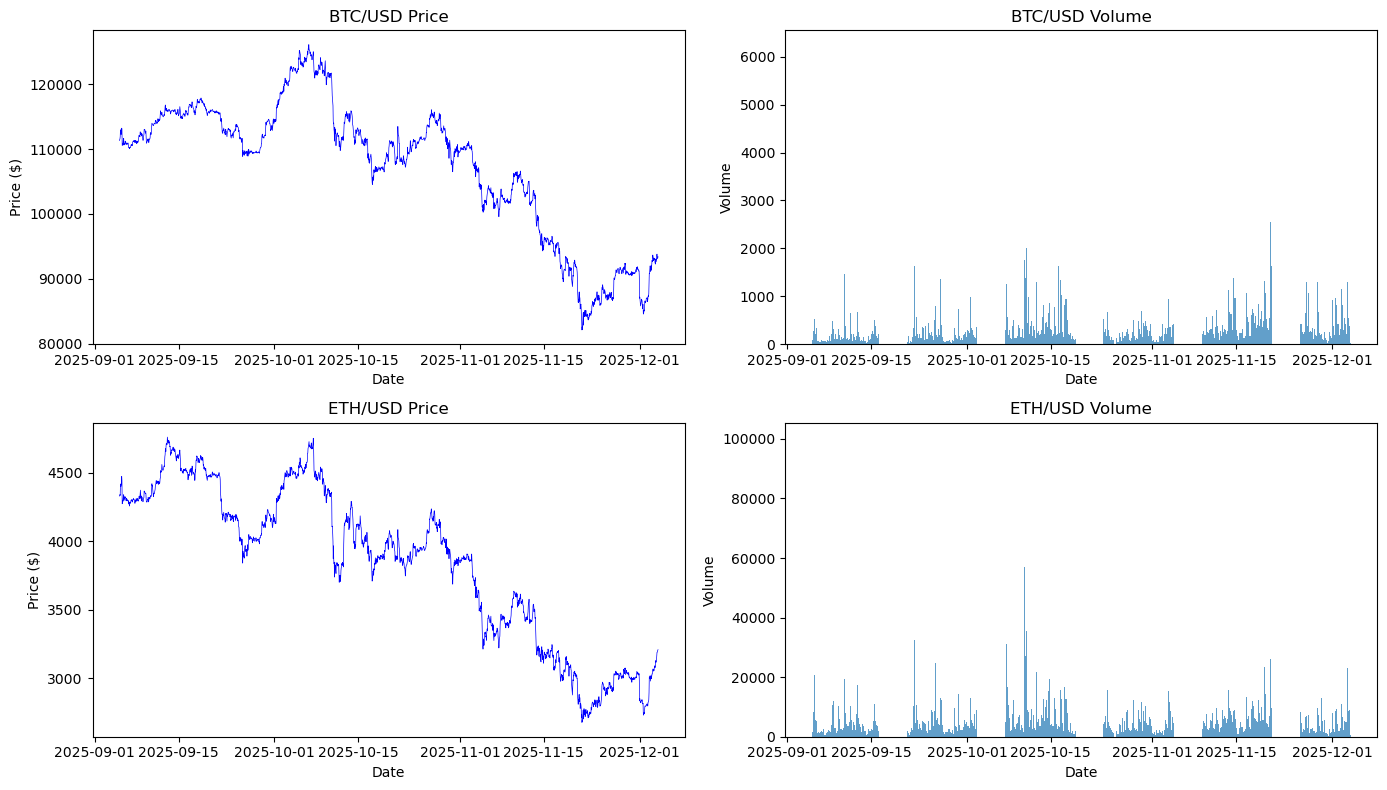


✓ Visual inspection complete - review charts for anomalies


In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# BTC Price
axes[0, 0].plot(btc_df['time'], btc_df['close'], 'b-', linewidth=0.5)
axes[0, 0].set_title('BTC/USD Price')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')

# BTC Volume
axes[0, 1].bar(btc_df['time'], btc_df['volume'], width=0.03, alpha=0.7)
axes[0, 1].set_title('BTC/USD Volume')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')

# ETH Price
axes[1, 0].plot(eth_df['time'], eth_df['close'], 'b-', linewidth=0.5)
axes[1, 0].set_title('ETH/USD Price')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price ($)')

# ETH Volume
axes[1, 1].bar(eth_df['time'], eth_df['volume'], width=0.03, alpha=0.7)
axes[1, 1].set_title('ETH/USD Volume')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volume')

plt.tight_layout()
plt.show()

print("\n✓ Visual inspection complete - review charts for anomalies")

## 6. Summary

In [11]:
# Close connections
db.close()

# Final summary
print("="*60)
print("PHASE 1 DATA PIPELINE VALIDATION: COMPLETE")
print("="*60)
print("\n✓ Exchange connection working")
print("✓ Database connection healthy")
print(f"✓ BTC/USD: {len(btc_df):,} rows")
print(f"✓ ETH/USD: {len(eth_df):,} rows")
print("✓ Data quality checks passed")
print("✓ Time continuity verified")
print("\n" + "="*60)
print("ALL CHECKS PASSED - Ready for feature engineering")
print("="*60)

PHASE 1 DATA PIPELINE VALIDATION: COMPLETE

✓ Exchange connection working
✓ Database connection healthy
✓ BTC/USD: 2,155 rows
✓ ETH/USD: 2,155 rows
✓ Data quality checks passed
✓ Time continuity verified

ALL CHECKS PASSED - Ready for feature engineering
